In [28]:
import numpy as np
import scipy
from scipy.sparse import csc_matrix, bmat, load_npz
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

## Load Data

In [29]:
s = load_npz("data/s.npz")
a_train = load_npz("data/a_train.npz")
a_test = load_npz("data/a_test.npz")

In [30]:
"parametar koji mnozi s"
alpha = 1

In [31]:
"citava matrica za trening"
c_train = bmat([[alpha*s, a_train], [a_train.transpose(), None]])
c_train

<35616x35616 sparse matrix of type '<class 'numpy.float64'>'
	with 398044 stored elements in COOrdinate format>

In [32]:
"citava matrica za test"
c_test = bmat([[alpha*s, a_test], [a_test.transpose(), None]])
c_test

<35616x35616 sparse matrix of type '<class 'numpy.float64'>'
	with 479906 stored elements in COOrdinate format>

## SVD

In [33]:
"svd ranga k trening matrice"
c_train = c_train.astype(np.float64)
"todo:trenirat k"
%time u, sig, vt = svds(c_train, k = 100)

CPU times: user 41 s, sys: 14.2 s, total: 55.2 s
Wall time: 7.8 s


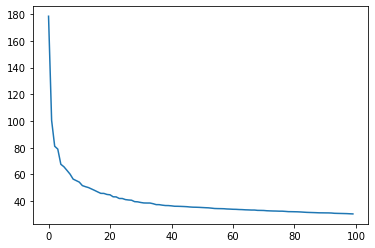

In [34]:
"singularne vrijednosti"
plt.plot(sig[::-1])

## Evaluacija SVD-a

In [70]:
"vrati listu (za k = 1:n) precisiona i recalla na testu za jednog usera"
def evaluate(i,n):
    "i = user za kojeg generiramo recommendatione"
    score1 = (u[i-1,:]@np.diag(sig)@vt)[-a_test.shape[1]:]
    score1 = np.flip(np.argsort(score1))
    
    true_labels = c_test.getrow(i-1).toarray().flatten()[-a_test.shape[1]:]
    
    positives = np.unique(true_labels, return_counts = True)[1][1] if np.unique(true_labels, return_counts = True)[1].shape[0] == 2\
                                                                   else np.unique(true_labels, return_counts = True)[1][0] * np.unique(true_labels, return_counts = True)[0][0]
    negatives = a_test.shape[1] - positives
    
    user_i_stats = []
    for predictions in range(1,n):
        recommendations = score1[:predictions]

        true_positives = np.unique(true_labels[recommendations] == 1, return_counts = True)[1][1] if np.unique(true_labels[recommendations] == 1, return_counts = True)[1].shape[0] == 2\
                                                  else np.unique(true_labels[recommendations] == 1, return_counts = True)[1][0] * np.unique(true_labels[recommendations] == 1, return_counts = True)[0][0]
        
        true_negatives = negatives - (predictions - true_positives)
        
        precision = true_positives/predictions
                
        sensitivity = true_positives/positives if positives != 0 else 1
        
        specificity = true_negatives/negatives
        
        user_i_stats.append((precision, sensitivity, specificity))

    return user_i_stats

In [71]:
"evaluiraj za sve usere i svakom daj neki fiksni broj recommendationa"
stats = []
for i in tqdm(range(s.shape[0])):
    stats.append(evaluate(i = i, n = 50))

100%|██████████| 15000/15000 [06:38<00:00, 37.61it/s]


In [72]:
pr_se_sp = []
for n in zip(*stats):
    pr_se_sp.append((np.mean([i for i,j,k in n]), np.mean([j for i,j,k in n]), np.mean([k for i,j,k in n])))

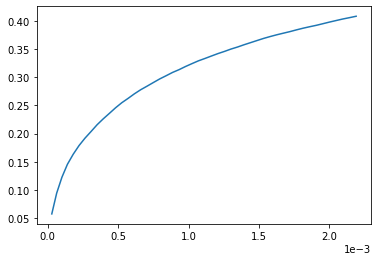

In [80]:
"graf iz papera, x = 1-specificity, y = sensitivity"
pss = np.array(pr_se_sp)
plt.plot(1 - pss[:,2], pss[:,1])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [65]:
np.savetxt("data/results.csv", pr, delimiter=",")

In [66]:
import pandas as pd
r = pd.read_csv("data/results.csv", header = None, names=["Precision", "Recall"])

## Katz

In [21]:
def katz(t, beta, k):
    katz = beta*t
    a = beta*t
    for i in range(k-1):
        a = beta*a@t
        katz = katz + a
    return katz

In [22]:
def katz_2(t, beta, k):
    t = t.astype(np.float64)
    u, s, vt = svds(t, k=3)
    s = np.diag(s)
    
    vtu = vt@u
    svtu = s@vtu
    
    katz = beta*s
    #a = beta*svtu
    small_matrix = beta * s @ vtu
    for i in range(k-1):
        small_matrix = beta * small_matrix @ s
        katz = katz + small_matrix
        small_matrix = small_matrix @ vtu
    katz = u @ katz @ vt
    return katz